In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# fid = drive.ListFile({'q':"title='license-plate-dataset.zip'"}).GetList()[0]['id']
# f = drive.CreateFile({'id': fid})
# f.GetContentFile('license-plate-dataset.zip')
# f.keys()
# !unzip license-plate-dataset.zip

In [3]:
#!pip install pytesseract
!pip install easyocr

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
#import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
path = glob('/kaggle/input/license-plate-dataset/train/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

for filename in path:
    info = xet.parse(filename)
    root = info.getroot()

    for member_object in root.findall('object'):
        for labels_info in member_object.findall('bndbox'):
            xmin = int(labels_info.find('xmin').text)
            xmax = int(labels_info.find('xmax').text)
            ymin = int(labels_info.find('ymin').text)
            ymax = int(labels_info.find('ymax').text)

            labels_dict['filepath'].append(filename)
            labels_dict['xmin'].append(xmin)
            labels_dict['xmax'].append(xmax)
            labels_dict['ymin'].append(ymin)
            labels_dict['ymax'].append(ymax)


In [6]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df = df[:2001]
#df.head()
df.tail()

,filepath,xmin,xmax,ymin,ymax
1996,/kaggle/input/license-plate-dataset/train/brig...,1,49,418,462
1997,/kaggle/input/license-plate-dataset/train/CarL...,173,307,481,552
1998,/kaggle/input/license-plate-dataset/train/Cars...,96,518,139,490
1999,/kaggle/input/license-plate-dataset/train/xema...,190,342,294,469
2000,/kaggle/input/license-plate-dataset/train/CarL...,196,322,294,369


In [7]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/kaggle/input/license-plate-dataset/train/',filename_image)
    return filepath_image
getFilename(filename)

'/kaggle/input/license-plate-dataset/train/xemay1495_jpg.rf.b05f218ae3a04e3c6e792a30aeb29cb8.jpg'

In [8]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]

['/kaggle/input/license-plate-dataset/train/xemay1495_jpg.rf.b05f218ae3a04e3c6e792a30aeb29cb8.jpg',
 '/kaggle/input/license-plate-dataset/train/pic_102_jpg.rf.986097023a58e6660c3a38b10b8d063a.jpg',
 '/kaggle/input/license-plate-dataset/train/xemay741_jpg.rf.14de31057a24adacc3d367c8742988a0.jpg',
 '/kaggle/input/license-plate-dataset/train/xemay1692_jpg.rf.f1fe76f2f3ce086eed39d48d424a760b.jpg',
 '/kaggle/input/license-plate-dataset/train/CarLongPlate592_jpg.rf.d6947d62e0419764afd3454172d82f1c.jpg',
 '/kaggle/input/license-plate-dataset/train/FSXY423_jpg.rf.3e4471446e0415079192b0c18308d0cd.jpg',
 '/kaggle/input/license-plate-dataset/train/pic_627_jpg.rf.bd12e7cd88ea3d2180b872af18bd9556.jpg',
 '/kaggle/input/license-plate-dataset/train/CarLongPlateGen1020_jpg.rf.30335ffa30a1092f53313b00aea22fdc.jpg',
 '/kaggle/input/license-plate-dataset/train/CarLongPlateGen2545_jpg.rf.59e272d50c6ff83699265fbb8e120b06.jpg',
 '/kaggle/input/license-plate-dataset/train/CarLongPlate383_jpg.rf.8c94973f61e980

In [9]:
#DATA VERIFICATION
file_path = image_path[321] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

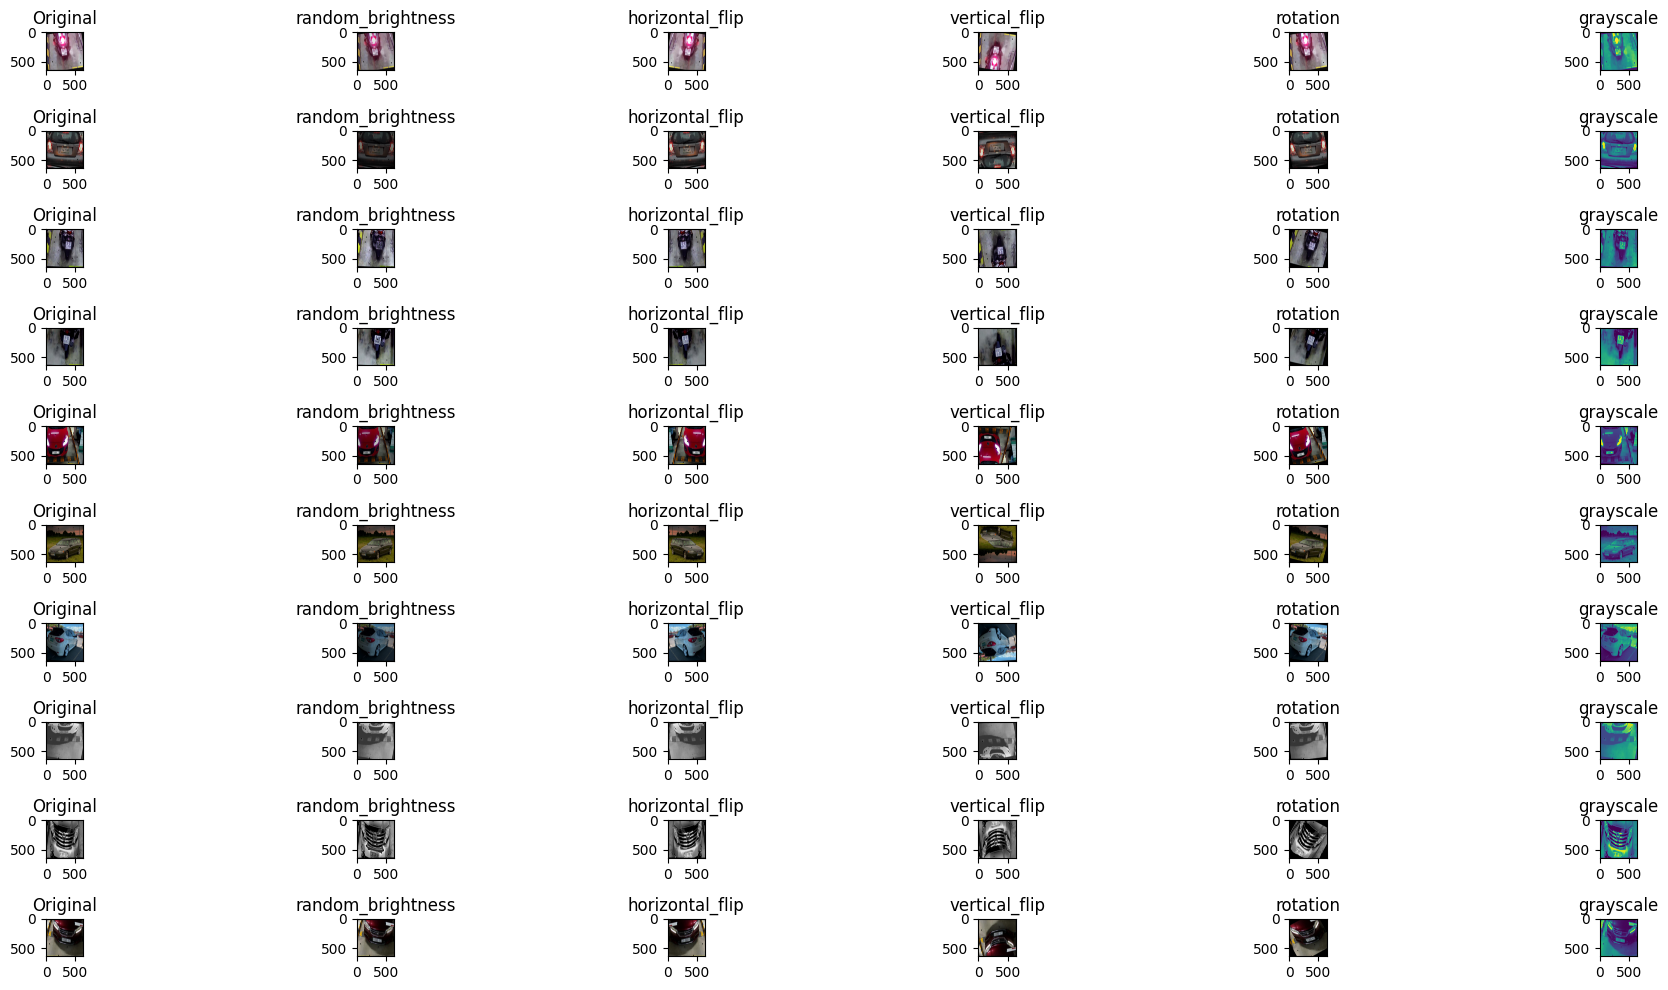

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

# Define the image path
image_path = list(df['filepath'].apply(getFilename))
image_path = image_path[:10]

# Define the augmentation functions
def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = random.uniform(0.5, 1.5)
    hsv[:,:,2] = hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def horizontal_flip(image):
    return cv2.flip(image, 1)

def vertical_flip(image):
    return cv2.flip(image, 0)

def rotation(image):
    rows, cols, _ = image.shape
    angle = random.randint(-30, 30)
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(image, M, (cols,rows))

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define the list of augmentation functions
augmentations = [random_brightness, horizontal_flip, vertical_flip, rotation, grayscale]

# Plot the original images and their augmentations
fig, axes = plt.subplots(nrows=len(image_path), ncols=len(augmentations)+1, figsize=(20, 10))

for i, path in enumerate(image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    for j, augmentation in enumerate(augmentations):
        aug_image = augmentation(image)
        axes[i, j+1].imshow(aug_image)
        axes[i, j+1].set_title(augmentation.__name__)

plt.tight_layout()
plt.show()


In [11]:
#DATA PROCESSING
labels = df.iloc[:,1:1000].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [12]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [13]:
# Split the data into training and testing set using sklearn.
# X = input features y = labels  random state=control the randomness of the train-test split, reproducibility
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((8, 224, 224, 3), (2, 224, 224, 3), (8, 4), (2, 4))

In [14]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/kaggle/input/license-plate-dataset/train/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,/kaggle/input/license-plate-dataset/train/xema...,240,374,256,413,/kaggle/input/license-plate-dataset/train/xema...,640,640
1,/kaggle/input/license-plate-dataset/train/pic_...,246,397,280,406,/kaggle/input/license-plate-dataset/train/pic_...,640,640
2,/kaggle/input/license-plate-dataset/train/xema...,313,440,196,355,/kaggle/input/license-plate-dataset/train/xema...,640,640
3,/kaggle/input/license-plate-dataset/train/xema...,278,415,124,319,/kaggle/input/license-plate-dataset/train/xema...,640,640
4,/kaggle/input/license-plate-dataset/train/CarL...,97,238,410,487,/kaggle/input/license-plate-dataset/train/CarL...,640,640


In [15]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,/kaggle/input/license-plate-dataset/train/xema...,240,374,256,413,/kaggle/input/license-plate-dataset/train/xema...,640,640,0.479687,0.522656,0.209375,0.245312
1,/kaggle/input/license-plate-dataset/train/pic_...,246,397,280,406,/kaggle/input/license-plate-dataset/train/pic_...,640,640,0.502344,0.535937,0.235937,0.196875
2,/kaggle/input/license-plate-dataset/train/xema...,313,440,196,355,/kaggle/input/license-plate-dataset/train/xema...,640,640,0.588281,0.430469,0.198437,0.248438
3,/kaggle/input/license-plate-dataset/train/xema...,278,415,124,319,/kaggle/input/license-plate-dataset/train/xema...,640,640,0.541406,0.346094,0.214062,0.304688
4,/kaggle/input/license-plate-dataset/train/CarL...,97,238,410,487,/kaggle/input/license-plate-dataset/train/CarL...,640,640,0.261719,0.700781,0.220312,0.120313


In [16]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15994, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15994 (delta 18), reused 18 (delta 12), pack-reused 15967
Receiving objects: 100% (15994/15994), 14.64 MiB | 23.00 MiB/s, done.
Resolving deltas: 100% (10980/10980), done.


In [17]:
!pip install -r ./yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 10.0 MB/s eta 0:00:00


In [18]:
mkdir /kaggle/working/yolov5/data_images/

In [19]:
mkdir /kaggle/working/yolov5/data_images/test/

In [20]:
mkdir /kaggle/working/yolov5/data_images/train/

In [21]:
### split the data into train and test
df_train = df.iloc[:1600]
df_test = df.iloc[1600:]

In [22]:
train_folder = '/kaggle/working/yolov5/data_images/train/'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

test_folder = '/kaggle/working/yolov5/data_images/test/'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

In [23]:
import yaml
yaml_dict = {'train': 'data_images/train',   # path to the train folder
            'val': 'data_images/test', # path to the val folder
            'nc': 1,                             # number of classes
            'names': ['liscence_plate']}                # list of label names

with open(r'./yolov5/data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [24]:
!nvidia-smi

Fri Sep 22 19:15:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
!pip install torch

In [26]:
!pip install GPUtil

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=f6e0c2bf1109b9f3f28c2b76eb92e15ac1e5e6a79dbd8ad4c7501f9ddc4f8063
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [27]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  9% |  2% |


In [28]:
#training with additional augmentation layer
#!python /content/yolov5/train.py --data /content/yolov5/data.yaml --cfg /content/yolov5/models/yolov5s.yaml --hyp hyp.scratch-low.yaml --batch-size 64 --name Model --epochs 3

#training
!python ./yolov5/train.py --data ./yolov5/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 32 --name Model --epochs 100

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
WARNING ⚠️ invalid check_version(3.1.31, ) requested, please check values.
train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=./yolov5/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank

In [29]:
# import onnx
# from onnx import utils

# model = onnx.load('model.onnx')
# model = utils.backward_compatible(model, target_version=11)
# onnx.save(model, 'model_v11.onnx')

In [30]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 2.0.0...
TorchScript: export success ✅ 2.8s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.14.1...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
=====================

In [31]:
!python ./yolov5/export.py --weights ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx --opset 11

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=11, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 2.0.0...
TorchScript: export success ✅ 2.9s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.14.1...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
=====================

In [32]:
#predictions

INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [33]:
# LOAD THE IMAGE
img = io.imread('/kaggle/input/bangladeshi-car-plates/test/327_jpg.rf.a1bcea24422b30732de987a7f8ade019.jpg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [34]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [35]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]

    return input_image, detections

def non_maximum_supression(input_image,detections):

    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE

    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)

    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    texts = []
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'Confidence: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])
        texts.append(license_text)


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_COMPLEX,0.7,(255,255,255),1)
        #cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_COMPLEX,0.7,(0,255,0),1)

    return image, texts

In [36]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img, texts = drawings(img,boxes_np,confidences_np,index)
    return result_img, texts

In [37]:
# # extrating text
# def extract_text(image,bbox):
#     x,y,w,h = bbox
#     roi = image[y:y+h, x:x+w]

#     if 0 in roi.shape:
#         return 'no number'

#     else:
#         text = pt.image_to_string(roi)
#         text = text.strip()

#         return text
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import easyocr

# initialize the EasyOCR reader
reader = easyocr.Reader(['bn'])

def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]

    if 0 in roi.shape:
        return 'no number'

    else:
        # extract text using EasyOCR
        result = reader.readtext(roi)
        text = ' '.join([res[1] for res in result])
        text = text.strip()

        return text

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [38]:
# test
from PIL import Image
img = Image.open('/kaggle/input/bangladeshi-car-plates/test/327_jpg.rf.a1bcea24422b30732de987a7f8ade019.jpg')

import numpy as np
img = np.array(img)
results, texts = yolo_predictions(img, net)
#texts


fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

print('\nDetected License Plate Text:', texts)


Detected License Plate Text: ['ঢাকা মেট্রো ১১-০৬২১']


In [39]:
# !pip uninstall opencv-python-headless -y

In [40]:
# !pip install opencv-python --upgrade

In [41]:
# import matplotlib.pyplot as plt
# import cv2
# import numpy as np

# cap = cv2.VideoCapture('/kaggle/input/car-plate-detection-bangla/bd_bmw_video.mp4')
# while True:
#     ret, frame = cap.read()

#     if ret == False:
#         print('Unable to read video')
#         break

#     for i in range(10):
#         ret = cap.grab()

# #     frame = denoise_img(frame)
# #     increase_contrast(frame)
#     results, texts = yolo_predictions(frame,net)
#     print(texts)

#     results = np.array(results)  # Convert to numpy array
#     results = cv2.cvtColor(results, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format

#     plt.imshow(results)
#     plt.show(block=False)
#     plt.pause(0.03)
#     plt.clf()

#     if plt.waitforbuttonpress(30/1000):
#         break

# cap.release()


In [42]:
# def denoise_img(img):
#     new_img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
#     plt.imshow(new_img)
#     plt.show(block=False)
#     plt.pause(0.03)
#     plt.clf()
#     return new_img

# def increase_contrast(img):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# #     cv2.imshow('Original Image', gray)
#     new_img = cv2.equalizeHist(img)
#     cv2.imshow('Equalized Image', img)
#     cv2.imshow('New Image', new_img)
#     cv2.waitKey(0)

